# Step 04: Have a look of image

In [1]:
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt

In [2]:
label_map_table = {
    0: "normal",
    1: "void",
    2: "Horizontal Defect",
    3: "Vertical Defect",
    4: "Edge Defect",
    5: "Partical"
}

[Label] => 3; [Label Actually Means] => Vertical Defect


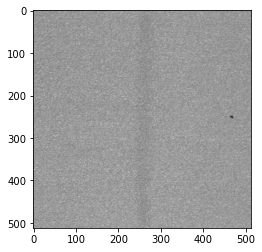

In [5]:
root_train = "./train_images/"
root_test = "./test_images/"
train_csv = "./train.csv"
test_csv = "./test.csv"
df_train = pd.read_csv(train_csv) # df stands for dataframe

id = 2525 # change this number to see other outcome
png_img = cv.imread(root_train + df_train.ID[id])
label = df_train.Label[id]
print(f"[Label] => {df_train.Label[id]}; [Label Actually Means] => {label_map_table[label]}")
plt.imshow(png_img)
plt.show()

# Step 05: Define Custom Dataset Class

In [6]:
from torch.utils.data.dataset import Dataset
from torchvision import transforms
import numpy as np
import pandas as pd
import cv2 as cv

In [7]:
# [Input Args]
# 1. target_csv <string>: It's the metadata file describe the name of image and its label.
# 2. root_path  <string>: It's the path to the image folder. Combination of this and name is the full path to the image.
# 3. height <int>: Use this for elastically resize image to desired shape.
# 4. width <int>: Use this for elastically resize image to desired shape.
class AOI_Dataset(Dataset):
    
    # perform logic operation: think what kind of info I need when loading data
    def __init__(self, target_csv, root_path, height, width, transform = None):
        
        # height, width
        self.height = height
        self.width = width
        
        # register self
        self.target_csv = target_csv
        self.root_path = root_path
        
        # 1. Read CSV file through root_path
        self.df = pd.read_csv(self.target_csv)
        
        # 2. Remember the length
        self.count = len(self.df)
        
        # 3. transform
        self.transforms = transform
    
    # input: index
    # output: pair of (image, lable)
    def __getitem__(self, index):
        # Read images
        img = cv.imread(self.root_path + self.df.ID[index])
        
        # Use resize to a smaller shape when training takes so long.
        img_resize = cv.resize(img, (self.height, self.width))

        # To Tensor
        img_tensor = self.transforms(np.uint8(img_resize))
        
        # Get label
        label = self.df.Label[index]
        
        return (img_tensor, label)
    
    def __len__(self):
        return self.count

# Step 06: Define DataLoader w.r.t Dataset Class

In [8]:
import torch
from torchvision import transforms

In [9]:
height = 512
width = 512

transform_train = transforms.Compose([
    transforms.ToTensor(),
    # add mroe in the future
])

Train_Dataset = AOI_Dataset(target_csv = train_csv, root_path = root_train, height = height, width = width, transform = transform_train)

batch_size = 8

Train_DataLoader = torch.utils.data.DataLoader(Train_Dataset, batch_size = batch_size)

# Step 07: Define LeNet5 - like Structure

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Use GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d( 3,  6, 3, padding = 1) # 加深 channel same
        self.conv2 = nn.Conv2d( 6, 16, 3, padding = 1) # 加深 channel
        self.conv3 = nn.Conv2d(16, 50, 3, padding = 1) # 加深 channel
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(50 * 64 * 64, 120) # Why 64 Why 50
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 6)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # 512 x 512 x  3 -> 256 x 256 x  6
        x = self.pool(F.relu(self.conv2(x))) # 256 x 256 x  6 -> 128 x 128 x 16
        x = self.pool(F.relu(self.conv3(x))) # 128 x 128 x 16 ->  64 x  64 x 50
        x = x.view(-1, 50 * 64 * 64)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        #x = F.softmax(x)
        return x
    
lenet = LeNet()
print(lenet.to(device))

cpu
LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=204800, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=6, bias=True)
)


# Step 08: Define Loss Function

In [15]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(lenet.parameters(), lr=1e-4) # learning rate is also adjustable
epoch = 10 # change this to whatever number you'd like

# Step 09: Training Phase

In [ ]:
from tqdm import tqdm
import time

tic = time.time()
train_acc_list = []
val_acc_list = []
loss_list = []
print_probe_num = 10

for epoch in range(epoch):  # loop over the dataset multiple times

    running_loss = 0.0
    
    for i, data in enumerate(Train_DataLoader, 0):
        # Select input and output pair
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # Clear gradient
        optimizer.zero_grad()

        # Forward Propagation
        outputs = lenet(inputs.float())
        
        # Compute Loss
        loss = criterion(outputs, labels)
        
        # Backward Propagation
        loss.backward()
        
        # Update Weight
        optimizer.step()

        # Just want to calculate the running loss 移動平均 loss!!
        running_loss += loss.item()
        if i % print_probe_num == (print_probe_num - 1):
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / print_probe_num))
            loss_list.append(running_loss / print_probe_num)
            running_loss = 0.0
            
    correct = 0
    total = 0
    
    # Train
    with torch.no_grad(): # since we're not training, we don't need to calculate the gradients for our outputs
        for datum in tqdm(Train_DataLoader):

            imgs, labs = datum[0].to(device), datum[1].to(device)
            # calculate outputs by running images through the network 
            outputs = lenet(imgs.float())
            # the class with the highest energy is what we choose as prediction
            _, preds = torch.max(outputs.data, 1)
            # [0.1 0.1 0.1 .... ]
            total += labs.size(0)
            correct += (preds == labs).sum().item()
        train_acc_list.append(float(correct)/float(total))
        print('Accuracy of the network on the train images: %d %%' % (100 * correct / total))

        
toc = time.time()
print(f"Spend {round(toc - tic, 2)} (sec)")
print('Finished Training')

[1,    10] loss: 1.750
[1,    20] loss: 1.684
[1,    30] loss: 1.725
[1,    40] loss: 1.726
[1,    50] loss: 1.684
[1,    60] loss: 1.694
[1,    70] loss: 1.730
[1,    80] loss: 1.614
[1,    90] loss: 1.629
[1,   100] loss: 1.558
[1,   110] loss: 1.551
[1,   120] loss: 1.513
[1,   130] loss: 1.681
[1,   140] loss: 1.592
[1,   150] loss: 1.534
[1,   160] loss: 1.450
[1,   170] loss: 1.545
[1,   180] loss: 1.432
[1,   190] loss: 1.563
[1,   200] loss: 1.463
[1,   210] loss: 1.246
[1,   220] loss: 1.509
[1,   230] loss: 1.369
[1,   240] loss: 1.396
[1,   250] loss: 1.270
[1,   260] loss: 1.291
[1,   270] loss: 1.395
[1,   280] loss: 1.329
[1,   290] loss: 1.374
[1,   300] loss: 1.393
[1,   310] loss: 1.303


100%|████████████████████████████████████████████████████████████████████████████████| 316/316 [01:31<00:00,  3.46it/s]


Accuracy of the network on the train images: 51 %
[2,    10] loss: 1.146
[2,    20] loss: 1.292
[2,    30] loss: 1.331
[2,    40] loss: 1.330
[2,    50] loss: 1.233
[2,    60] loss: 1.315
[2,    70] loss: 1.306
[2,    80] loss: 1.112
[2,    90] loss: 1.231
[2,   100] loss: 1.085
[2,   110] loss: 1.113
[2,   120] loss: 1.176
[2,   130] loss: 1.382
[2,   140] loss: 1.222
[2,   150] loss: 1.203
[2,   160] loss: 1.043
[2,   170] loss: 1.143
[2,   180] loss: 1.110
[2,   190] loss: 1.197
[2,   200] loss: 1.101
[2,   210] loss: 0.915
[2,   220] loss: 1.193
[2,   230] loss: 1.096
[2,   240] loss: 1.036
[2,   250] loss: 0.949
[2,   260] loss: 0.989
[2,   270] loss: 1.113
[2,   280] loss: 1.036
[2,   290] loss: 1.110
[2,   300] loss: 1.116
[2,   310] loss: 0.983


100%|████████████████████████████████████████████████████████████████████████████████| 316/316 [01:34<00:00,  3.36it/s]


Accuracy of the network on the train images: 63 %
[3,    10] loss: 0.907
[3,    20] loss: 1.060
[3,    30] loss: 1.055
[3,    40] loss: 1.007
[3,    50] loss: 1.049
[3,    60] loss: 1.003
[3,    70] loss: 0.993
[3,    80] loss: 0.828
[3,    90] loss: 1.088
[3,   100] loss: 0.886
[3,   110] loss: 0.875
[3,   120] loss: 1.049
[3,   130] loss: 1.149
[3,   140] loss: 1.053
[3,   150] loss: 0.950
[3,   160] loss: 0.754
[3,   170] loss: 0.934
[3,   180] loss: 0.929
[3,   190] loss: 0.947
[3,   200] loss: 0.874
[3,   210] loss: 0.718
[3,   220] loss: 1.002
[3,   230] loss: 0.876
[3,   240] loss: 0.870
[3,   250] loss: 0.731
[3,   260] loss: 0.820
[3,   270] loss: 0.924
[3,   280] loss: 0.867
[3,   290] loss: 0.900
[3,   300] loss: 0.903
[3,   310] loss: 0.778


100%|████████████████████████████████████████████████████████████████████████████████| 316/316 [01:39<00:00,  3.17it/s]


Accuracy of the network on the train images: 70 %
[4,    10] loss: 0.726
[4,    20] loss: 0.915
[4,    30] loss: 0.844
[4,    40] loss: 0.783
[4,    50] loss: 0.955
[4,    60] loss: 0.786
[4,    70] loss: 0.821
[4,    80] loss: 0.670
[4,    90] loss: 0.957
[4,   100] loss: 0.742
[4,   110] loss: 0.713
[4,   120] loss: 0.925
[4,   130] loss: 0.975
[4,   140] loss: 0.887
[4,   150] loss: 0.779
[4,   160] loss: 0.639
[4,   170] loss: 0.833
[4,   180] loss: 0.782
[4,   190] loss: 0.775
[4,   200] loss: 0.698


# Step 10: Plot Accuracy & Loss Curves

In [ ]:
import matplotlib.pyplot as plt

## Accuracy

plt.figure(figsize = (20, 10))
plt.title("LeNet5: Accuracy Curve", fontsize = 24)
plt.xlabel("Epochs"    , fontsize = 20)
plt.ylabel("Accuracy %", fontsize = 20)
plt.plot(train_acc_list, label = "train acc.")
plt.legend(loc = 2, fontsize = 20)
plt.show()

## Loss

plt.figure(figsize=(20, 10))
plt.title("LeNet5: Loss Curve", fontsize = 24)
plt.plot(loss_list)
plt.xlabel("Probes", fontsize = 20)
plt.ylabel("Loss", fontsize = 20)
plt.show()

# Step 11: Testing Phase

In [ ]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
])

Test_Dataset = AOI_Dataset(target_csv = test_csv, root_path = root_test, height = height, width = width, transform = transform_test)
Test_DataLoader = torch.utils.data.DataLoader(dataset = Test_Dataset, batch_size = 1, shuffle = False)
Name_of_csv_file = "AI.FREE.SUCCESS.csv"

df_test = pd.read_csv(test_csv)
df_test_np = df_test.to_numpy()

count = -1
with torch.no_grad(): # since we're not training, we don't need to calculate the gradients for our outputs
    for datum in tqdm(Test_DataLoader):
        count = count + 1
        imgs = datum[0].to(device)
        # calculate outputs by running images through the network 
        outputs = lenet(imgs.float())
        # the class with the highest energy is what we choose as prediction
        _, preds = torch.max(outputs.data, 1)
        df_test_np[count][1] = float(preds)
        
df = pd.DataFrame(df_test_np, columns = ['ID','Label'])
df.to_csv(Name_of_csv_file, index=False)